# Machine Learning Model for RC Beam Frequency Prediction
## Part 2: Model Training and Validation

**Objective:** Develop and validate machine learning models to predict natural frequencies of corroded RC beams.

**Author:** Master's Research Project  
**Date:** November 2025

## 1. Setup and Imports

In [4]:
!pip install catboost
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension
import catboost
print(catboost.__version__)


usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

options:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: console contrib dejavu events execute kernel kernelspec
lab labextension labhub migrate nbconvert nbextensions_configurator notebook
run server troubleshoot trust

Jupyter command `jupyter-nbextension` not found.
1.2.8


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import logging
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# ML Libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
import xgboost as xgb
from catboost import CatBoostRegressor
import shap
import joblib

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

print("✓ All libraries imported successfully")

✓ All libraries imported successfully


## 2. Configure Logging System

In [6]:
# Setup logging
log_dir = Path('simulation/logs')
log_dir.mkdir(parents=True, exist_ok=True)

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler(log_dir / 'ml_training.log'),
        logging.StreamHandler()
    ]
)

logger = logging.getLogger(__name__)
logger.info("=" * 80)
logger.info("ML MODEL TRAINING INITIALIZED")
logger.info("=" * 80)

2025-11-26 21:36:23,700 - INFO - ================================================================================
2025-11-26 21:36:23,701 - INFO - ML MODEL TRAINING INITIALIZED
2025-11-26 21:36:23,701 - INFO - ================================================================================


## 3. Data Loading and Initial Exploration

In [7]:
# Load dataset
data_path = Path('simulation/data/beam_vibration_dataset.csv')
logger.info(f"Loading dataset from: {data_path}")

try:
    df = pd.read_csv(data_path)
    logger.info(f"✓ Dataset loaded successfully: {df.shape[0]} samples, {df.shape[1]} features")
except Exception as e:
    logger.error(f"Failed to load dataset: {e}")
    raise

# Display basic information
print("\n" + "="*80)
print("DATASET OVERVIEW")
print("="*80)
print(f"\nShape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nFirst 5 rows:")
df.head()

2025-11-26 21:36:23,708 - INFO - Loading dataset from: simulation/data/beam_vibration_dataset.csv
2025-11-26 21:36:23,714 - INFO - ✓ Dataset loaded successfully: 3000 samples, 9 features



DATASET OVERVIEW

Shape: (3000, 9)

Columns: ['ID', 'Length', 'Width', 'Depth', 'Conc_Strength', 'Damage_Type', 'Damage_Severity', 'Freq_Mode_1', 'Freq_Mode_2']

First 5 rows:


,ID,Length,Width,Depth,Conc_Strength,Damage_Type,Damage_Severity,Freq_Mode_1,Freq_Mode_2
0,0,4.637043,0.442656,0.532357,39.452522,none,0.0,89.257102,246.044152
1,1,4.934843,0.304902,0.596373,48.376783,none,0.0,92.903946,256.096962
2,2,7.633120,0.207955,0.468938,33.175610,none,0.0,27.785595,76.593158
3,3,6.195594,0.486218,0.576926,31.923106,none,0.0,51.390655,141.662344
4,4,6.932409,0.408994,0.701362,38.536403,none,0.0,52.305244,144.183477


In [8]:
# Statistical summary
print("\n" + "="*80)
print("STATISTICAL SUMMARY")
print("="*80)
df.describe()


STATISTICAL SUMMARY


,ID,Length,Width,Depth,Conc_Strength,Damage_Severity,Freq_Mode_1,Freq_Mode_2
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,1499.500000,5.500006,0.350000,0.550000,37.500009,30.967056,77.545665,213.486543
std,866.169729,1.443621,0.086617,0.144362,7.218068,35.026253,51.947845,142.937245
min,0.000000,3.000379,0.200094,0.300160,25.007120,0.000000,13.673586,37.692304
25%,749.750000,4.250200,0.275047,0.425019,31.254756,0.000000,39.510497,108.873811
50%,1499.500000,5.499400,0.350013,0.549938,37.501238,18.719913,60.149595,165.578303
75%,2249.250000,6.749076,0.425013,0.674924,43.745723,58.589659,101.578953,280.194541
max,2999.000000,7.999907,0.499927,0.799871,49.996896,120.000000,301.680220,833.026520


In [9]:
# Check for missing values
missing_values = df.isnull().sum()
if missing_values.any():
    logger.warning(f"Missing values detected:\n{missing_values[missing_values > 0]}")
else:
    logger.info("✓ No missing values detected")

# Data types
print("\nData Types:")
print(df.dtypes)

2025-11-26 21:36:23,769 - INFO - ✓ No missing values detected



Data Types:
ID                   int64
Length             float64
Width              float64
Depth              float64
Conc_Strength      float64
Damage_Type         object
Damage_Severity    float64
Freq_Mode_1        float64
Freq_Mode_2        float64
dtype: object


## 4. Exploratory Data Analysis (EDA)

In [10]:
# Create output directory for figures
output_dir = Path('simulation/outputs/ml_figures')
output_dir.mkdir(parents=True, exist_ok=True)
logger.info(f"Output directory created: {output_dir}")

2025-11-26 21:36:23,775 - INFO - Output directory created: simulation/outputs/ml_figures


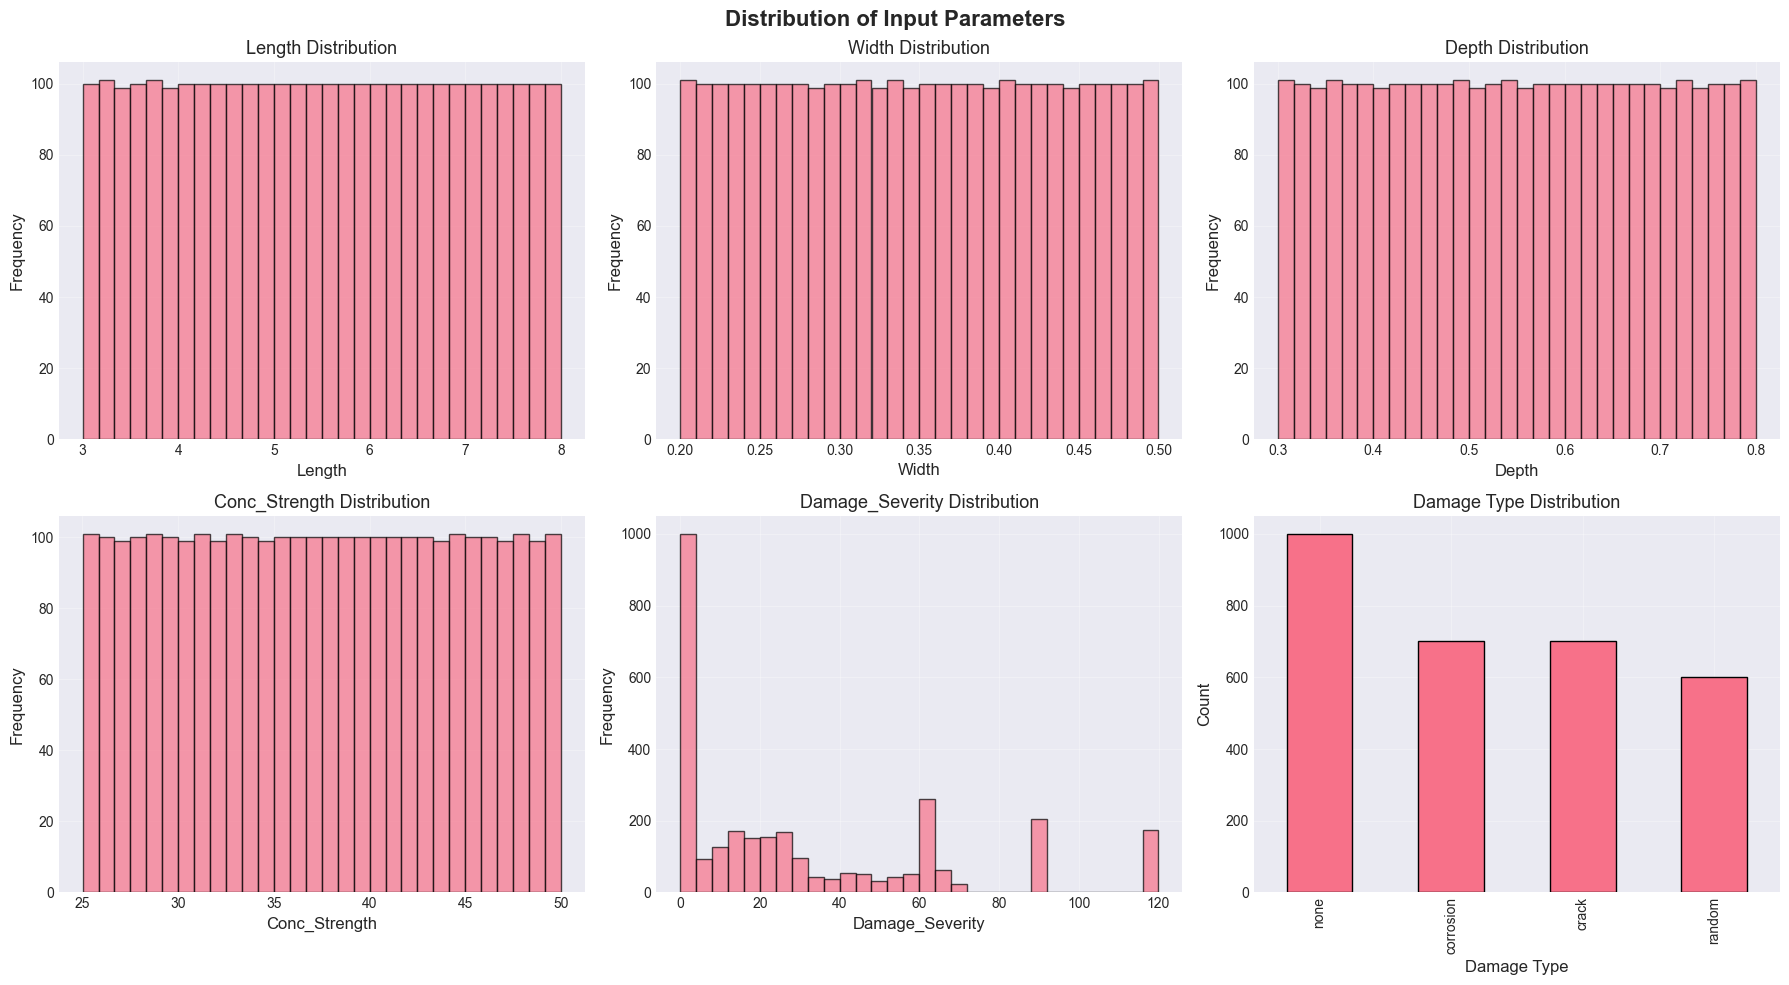

2025-11-26 21:36:25,102 - INFO - ✓ Parameter distribution plot saved


In [11]:
# Distribution of input features
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Distribution of Input Parameters', fontsize=16, fontweight='bold')

features = ['Length', 'Width', 'Depth', 'Conc_Strength', 'Damage_Severity']
for idx, feature in enumerate(features):
    ax = axes[idx // 3, idx % 3]
    ax.hist(df[feature], bins=30, edgecolor='black', alpha=0.7)
    ax.set_xlabel(feature, fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.set_title(f'{feature} Distribution', fontsize=13)
    ax.grid(alpha=0.3)

# Damage type distribution
ax = axes[1, 2]
df['Damage_Type'].value_counts().plot(kind='bar', ax=ax, edgecolor='black')
ax.set_xlabel('Damage Type', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Damage Type Distribution', fontsize=13)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(output_dir / 'parameter_distributions.png', dpi=300, bbox_inches='tight')
plt.show()
logger.info("✓ Parameter distribution plot saved")

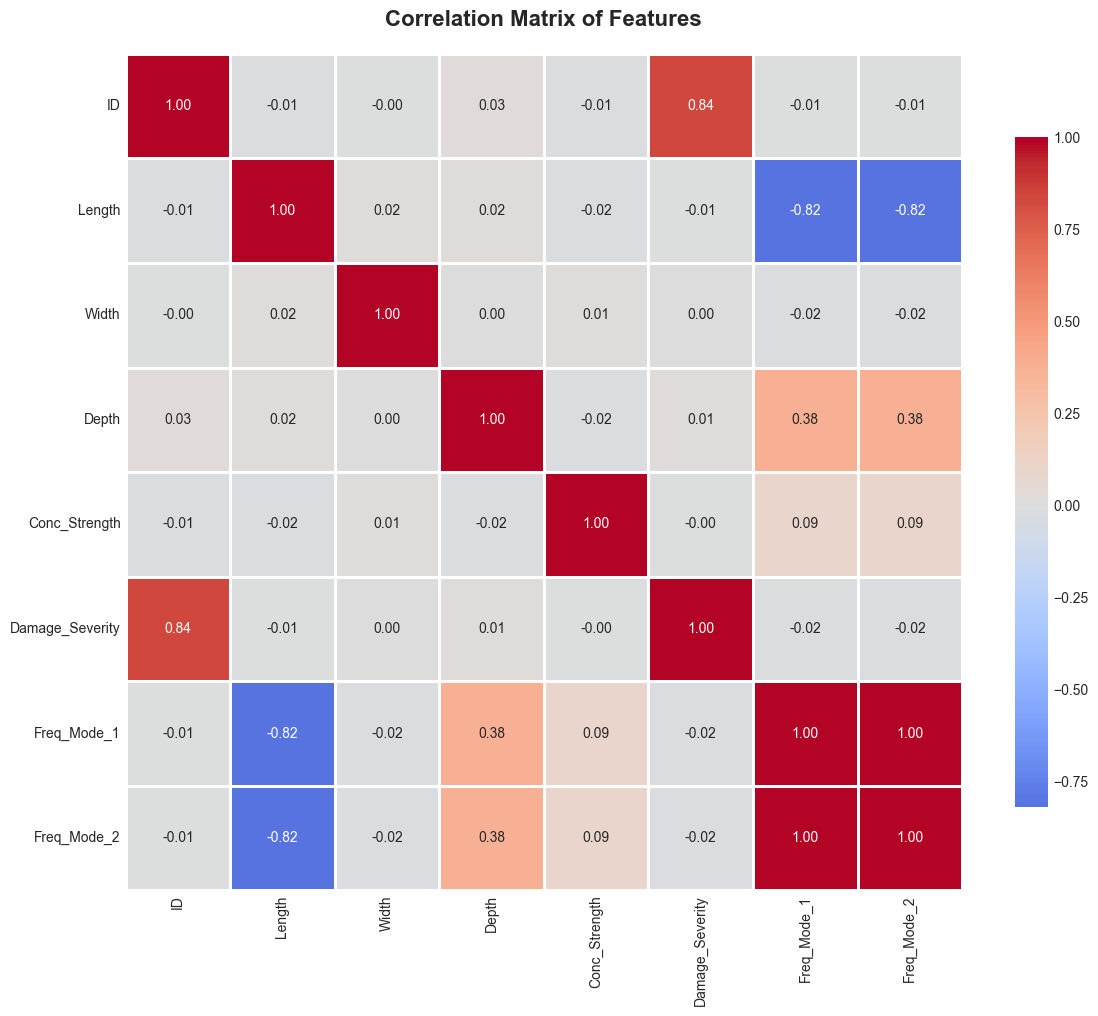

2025-11-26 21:36:25,463 - INFO - ✓ Correlation matrix saved



Correlations with Mode 1 Frequency:
Freq_Mode_1        1.000000
Freq_Mode_2        0.999621
Depth              0.380641
Conc_Strength      0.092727
ID                -0.005037
Damage_Severity   -0.015356
Width             -0.019226
Length            -0.818332
Name: Freq_Mode_1, dtype: float64


In [12]:
# Correlation analysis
numeric_cols = df.select_dtypes(include=[np.number]).columns
correlation_matrix = df[numeric_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix of Features', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig(output_dir / 'correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()
logger.info("✓ Correlation matrix saved")

# Log key correlations with target
print("\nCorrelations with Mode 1 Frequency:")
print(correlation_matrix['Freq_Mode_1'].sort_values(ascending=False))

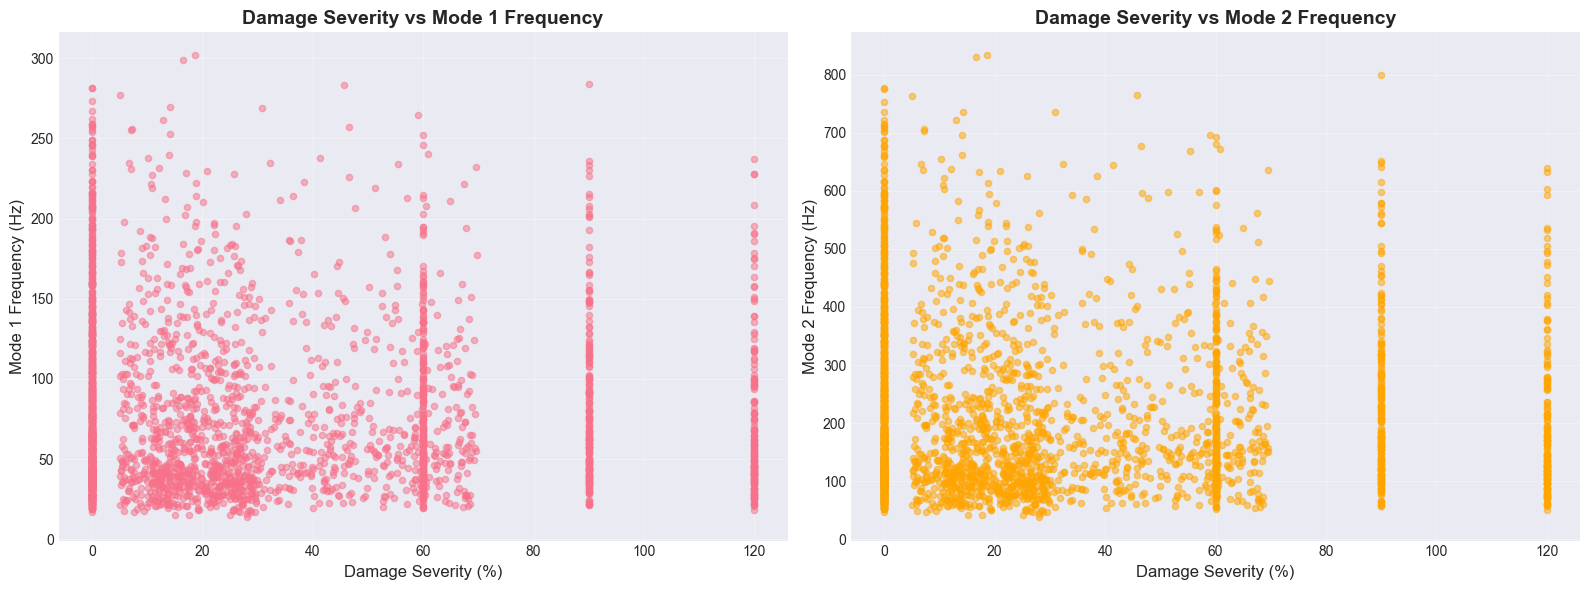

2025-11-26 21:36:25,922 - INFO - ✓ Damage vs frequency plot saved


In [13]:
# Damage severity vs frequency
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Mode 1
axes[0].scatter(df['Damage_Severity'], df['Freq_Mode_1'], alpha=0.5, s=20)
axes[0].set_xlabel('Damage Severity (%)', fontsize=12)
axes[0].set_ylabel('Mode 1 Frequency (Hz)', fontsize=12)
axes[0].set_title('Damage Severity vs Mode 1 Frequency', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)

# Mode 2
axes[1].scatter(df['Damage_Severity'], df['Freq_Mode_2'], alpha=0.5, s=20, color='orange')
axes[1].set_xlabel('Damage Severity (%)', fontsize=12)
axes[1].set_ylabel('Mode 2 Frequency (Hz)', fontsize=12)
axes[1].set_title('Damage Severity vs Mode 2 Frequency', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(output_dir / 'damage_vs_frequency.png', dpi=300, bbox_inches='tight')
plt.show()
logger.info("✓ Damage vs frequency plot saved")

## 5. Data Preprocessing

In [14]:
# Prepare features and target
logger.info("Preparing features and target variables")

# Define features and targets
feature_cols = ['Length', 'Width', 'Depth', 'Conc_Strength', 'Damage_Severity']
target_col = 'Freq_Mode_1'

X = df[feature_cols]
y = df[target_col]

logger.info(f"Features shape: {X.shape}")
logger.info(f"Target shape: {y.shape}")
logger.info(f"Feature columns: {feature_cols}")

print(f"\nFeatures (X): {X.shape}")
print(f"Target (y): {y.shape}")

2025-11-26 21:36:25,943 - INFO - Preparing features and target variables
2025-11-26 21:36:25,945 - INFO - Features shape: (3000, 5)
2025-11-26 21:36:25,946 - INFO - Target shape: (3000,)
2025-11-26 21:36:25,952 - INFO - Feature columns: ['Length', 'Width', 'Depth', 'Conc_Strength', 'Damage_Severity']



Features (X): (3000, 5)
Target (y): (3000,)


In [15]:
# Train-test split with stratification
logger.info("Splitting data into train and test sets (80/20)")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, shuffle=True
)

logger.info(f"Train set: {X_train.shape[0]} samples")
logger.info(f"Test set: {X_test.shape[0]} samples")

print(f"\nTraining samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")

2025-11-26 21:36:25,997 - INFO - Splitting data into train and test sets (80/20)
2025-11-26 21:36:26,000 - INFO - Train set: 2400 samples
2025-11-26 21:36:26,001 - INFO - Test set: 600 samples



Training samples: 2400
Testing samples: 600


In [16]:
# Feature scaling
logger.info("Applying StandardScaler to features")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

logger.info("✓ Feature scaling completed")
print("\n✓ Data preprocessing completed")

2025-11-26 21:36:26,008 - INFO - Applying StandardScaler to features
2025-11-26 21:36:26,011 - INFO - ✓ Feature scaling completed



✓ Data preprocessing completed


## 6. Model Training and Evaluation

In [17]:
# Dictionary to store models and results
models = {}
results = []

def evaluate_model(name, model, X_tr, y_tr, X_te, y_te, use_scaling=True):
    """Train and evaluate a model with comprehensive metrics."""
    logger.info(f"\n{'='*80}")
    logger.info(f"Training {name}")
    logger.info(f"{'='*80}")
    
    # Select scaled or unscaled data
    X_train_data = X_tr if use_scaling else X_train
    X_test_data = X_te if use_scaling else X_test
    
    # Train model
    model.fit(X_train_data, y_tr)
    logger.info(f"✓ {name} training completed")
    
    # Predictions
    y_train_pred = model.predict(X_train_data)
    y_test_pred = model.predict(X_test_data)
    
    # Calculate metrics
    train_mae = mean_absolute_error(y_tr, y_train_pred)
    train_rmse = np.sqrt(mean_squared_error(y_tr, y_train_pred))
    train_r2 = r2_score(y_tr, y_train_pred)
    
    test_mae = mean_absolute_error(y_te, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_te, y_test_pred))
    test_r2 = r2_score(y_te, y_test_pred)
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_train_data, y_tr, cv=5, scoring='r2')
    cv_mean = cv_scores.mean()
    cv_std = cv_scores.std()
    
    # Log results
    logger.info(f"Train MAE: {train_mae:.4f}, RMSE: {train_rmse:.4f}, R²: {train_r2:.4f}")
    logger.info(f"Test MAE: {test_mae:.4f}, RMSE: {test_rmse:.4f}, R²: {test_r2:.4f}")
    logger.info(f"CV R² Score: {cv_mean:.4f} ± {cv_std:.4f}")
    
    # Store results
    results.append({
        'Model': name,
        'Train_MAE': train_mae,
        'Train_RMSE': train_rmse,
        'Train_R2': train_r2,
        'Test_MAE': test_mae,
        'Test_RMSE': test_rmse,
        'Test_R2': test_r2,
        'CV_R2_Mean': cv_mean,
        'CV_R2_Std': cv_std
    })
    
    return model, y_test_pred

print("Model evaluation function defined")

Model evaluation function defined


### 6.1 Linear Regression (Baseline)

In [18]:
lr_model = LinearRegression()
lr_trained, lr_predictions = evaluate_model(
    'Linear Regression', lr_model, X_train_scaled, y_train, X_test_scaled, y_test
)
models['Linear Regression'] = (lr_trained, lr_predictions)

2025-11-26 21:36:26,025 - INFO - 
2025-11-26 21:36:26,026 - INFO - Training Linear Regression
2025-11-26 21:36:26,026 - INFO - ================================================================================
2025-11-26 21:36:26,031 - INFO - ✓ Linear Regression training completed
2025-11-26 21:36:26,038 - INFO - Train MAE: 15.9297, RMSE: 20.9838, R²: 0.8338
2025-11-26 21:36:26,039 - INFO - Test MAE: 17.0490, RMSE: 22.2765, R²: 0.8284
2025-11-26 21:36:26,039 - INFO - CV R² Score: 0.8327 ± 0.0058


### 6.2 Random Forest Regressor

In [19]:
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=0
)
rf_trained, rf_predictions = evaluate_model(
    'Random Forest', rf_model, X_train_scaled, y_train, X_test_scaled, y_test
)
models['Random Forest'] = (rf_trained, rf_predictions)

2025-11-26 21:36:26,045 - INFO - 
2025-11-26 21:36:26,045 - INFO - Training Random Forest
2025-11-26 21:36:26,045 - INFO - ================================================================================
2025-11-26 21:36:26,246 - INFO - ✓ Random Forest training completed
2025-11-26 21:36:27,219 - INFO - Train MAE: 2.2241, RMSE: 3.6514, R²: 0.9950
2025-11-26 21:36:27,219 - INFO - Test MAE: 4.6553, RMSE: 7.9916, R²: 0.9779
2025-11-26 21:36:27,219 - INFO - CV R² Score: 0.9780 ± 0.0033


### 6.3 XGBoost Regressor

In [20]:
xgb_model = xgb.XGBRegressor(
    n_estimators=200,
    max_depth=8,
    learning_rate=0.1,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbosity=0
)
xgb_trained, xgb_predictions = evaluate_model(
    'XGBoost', xgb_model, X_train_scaled, y_train, X_test_scaled, y_test
)
models['XGBoost'] = (xgb_trained, xgb_predictions)

2025-11-26 21:36:27,226 - INFO - 
2025-11-26 21:36:27,227 - INFO - Training XGBoost
2025-11-26 21:36:27,227 - INFO - ================================================================================
2025-11-26 21:36:27,795 - INFO - ✓ XGBoost training completed
2025-11-26 21:36:30,658 - INFO - Train MAE: 0.2510, RMSE: 0.3653, R²: 0.9999
2025-11-26 21:36:30,659 - INFO - Test MAE: 4.0559, RMSE: 7.3766, R²: 0.9812
2025-11-26 21:36:30,659 - INFO - CV R² Score: 0.9818 ± 0.0040


### 6.4 CatBoost Regressor

In [21]:
cb_model = CatBoostRegressor(
    iterations=200,
    depth=8,
    learning_rate=0.1,
    random_state=RANDOM_STATE,
    verbose=False
)
cb_trained, cb_predictions = evaluate_model(
    'CatBoost', cb_model, X_train_scaled, y_train, X_test_scaled, y_test
)
models['CatBoost'] = (cb_trained, cb_predictions)

2025-11-26 21:36:30,666 - INFO - 
2025-11-26 21:36:30,667 - INFO - Training CatBoost
2025-11-26 21:36:30,667 - INFO - ================================================================================
2025-11-26 21:36:30,971 - INFO - ✓ CatBoost training completed
2025-11-26 21:36:32,178 - INFO - Train MAE: 1.7414, RMSE: 2.5847, R²: 0.9975
2025-11-26 21:36:32,178 - INFO - Test MAE: 3.0023, RMSE: 5.6119, R²: 0.9891
2025-11-26 21:36:32,179 - INFO - CV R² Score: 0.9894 ± 0.0019


### 6.5 Support Vector Regression

In [22]:
svr_model = SVR(kernel='rbf', C=100, gamma='scale', epsilon=0.1)
svr_trained, svr_predictions = evaluate_model(
    'SVR', svr_model, X_train_scaled, y_train, X_test_scaled, y_test
)
models['SVR'] = (svr_trained, svr_predictions)

2025-11-26 21:36:32,185 - INFO - 
2025-11-26 21:36:32,185 - INFO - Training SVR
2025-11-26 21:36:32,186 - INFO - ================================================================================
2025-11-26 21:36:32,818 - INFO - ✓ SVR training completed
2025-11-26 21:36:35,098 - INFO - Train MAE: 2.9658, RMSE: 5.7405, R²: 0.9876
2025-11-26 21:36:35,098 - INFO - Test MAE: 3.7959, RMSE: 7.5078, R²: 0.9805
2025-11-26 21:36:35,098 - INFO - CV R² Score: 0.9832 ± 0.0024


## 7. Model Comparison and Visualization

In [23]:
# Create results dataframe
results_df = pd.DataFrame(results)
print("\n" + "="*80)
print("MODEL COMPARISON RESULTS")
print("="*80)
print(results_df.to_string(index=False))

# Save results
results_df.to_csv(output_dir / 'model_comparison.csv', index=False)
logger.info("✓ Results saved to CSV")

2025-11-26 21:36:35,108 - INFO - ✓ Results saved to CSV



MODEL COMPARISON RESULTS
            Model  Train_MAE  Train_RMSE  Train_R2  Test_MAE  Test_RMSE  Test_R2  CV_R2_Mean  CV_R2_Std
Linear Regression  15.929720   20.983824  0.833777 17.048993  22.276529 0.828429    0.832713   0.005845
    Random Forest   2.224104    3.651375  0.994967  4.655326   7.991593 0.977919    0.978029   0.003307
          XGBoost   0.251025    0.365336  0.999950  4.055851   7.376644 0.981187    0.981841   0.004040
         CatBoost   1.741409    2.584724  0.997478  3.002346   5.611933 0.989111    0.989418   0.001908
              SVR   2.965844    5.740466  0.987560  3.795853   7.507815 0.980512    0.983204   0.002407


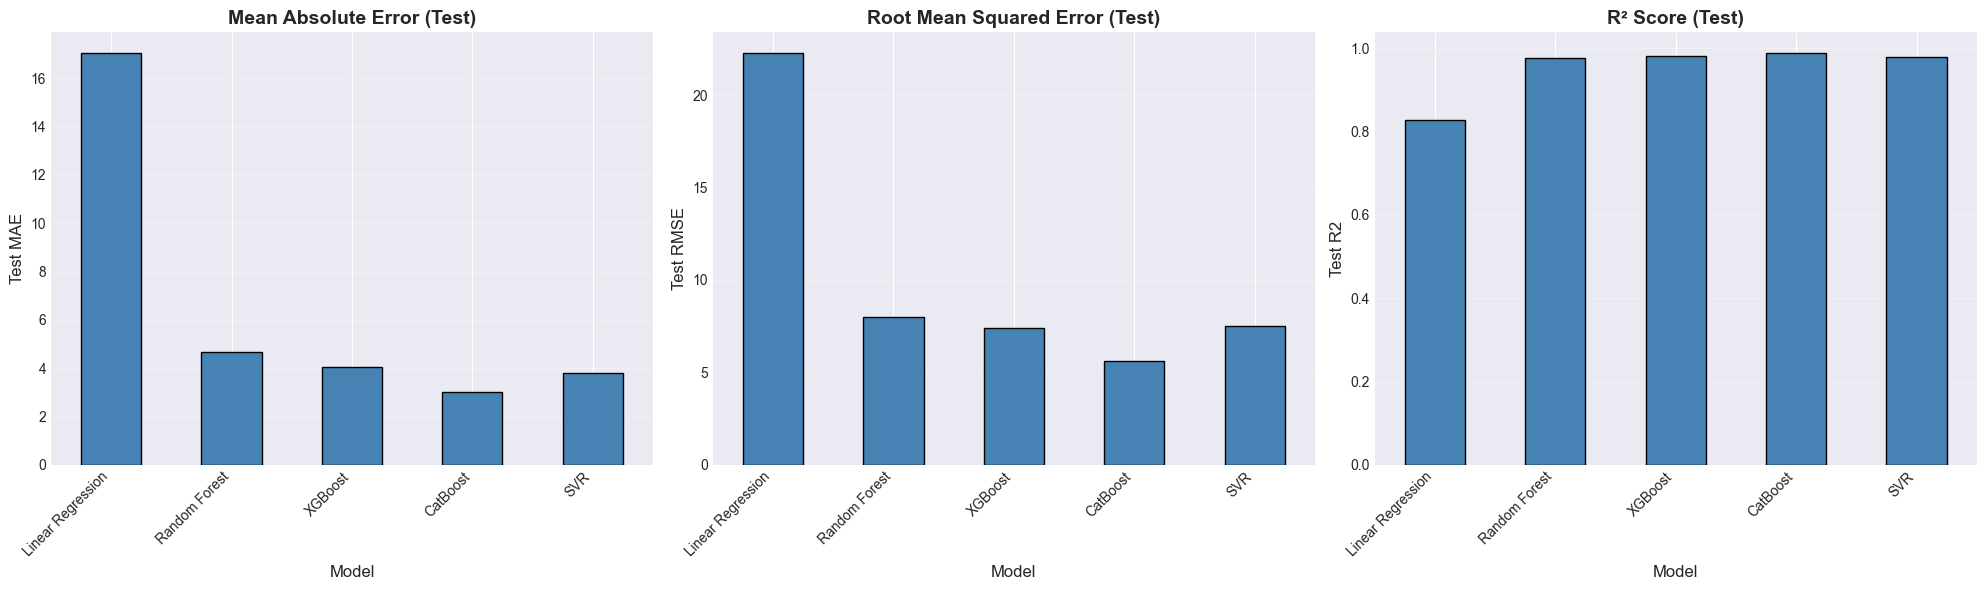

2025-11-26 21:36:35,549 - INFO - ✓ Model comparison plot saved


In [24]:
# Comparison bar plots
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

metrics = ['Test_MAE', 'Test_RMSE', 'Test_R2']
titles = ['Mean Absolute Error (Test)', 'Root Mean Squared Error (Test)', 'R² Score (Test)']

for idx, (metric, title) in enumerate(zip(metrics, titles)):
    ax = axes[idx]
    results_df.plot(x='Model', y=metric, kind='bar', ax=ax, legend=False, color='steelblue', edgecolor='black')
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_ylabel(metric.replace('_', ' '), fontsize=12)
    ax.set_xlabel('Model', fontsize=12)
    ax.grid(axis='y', alpha=0.3)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig(output_dir / 'model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
logger.info("✓ Model comparison plot saved")

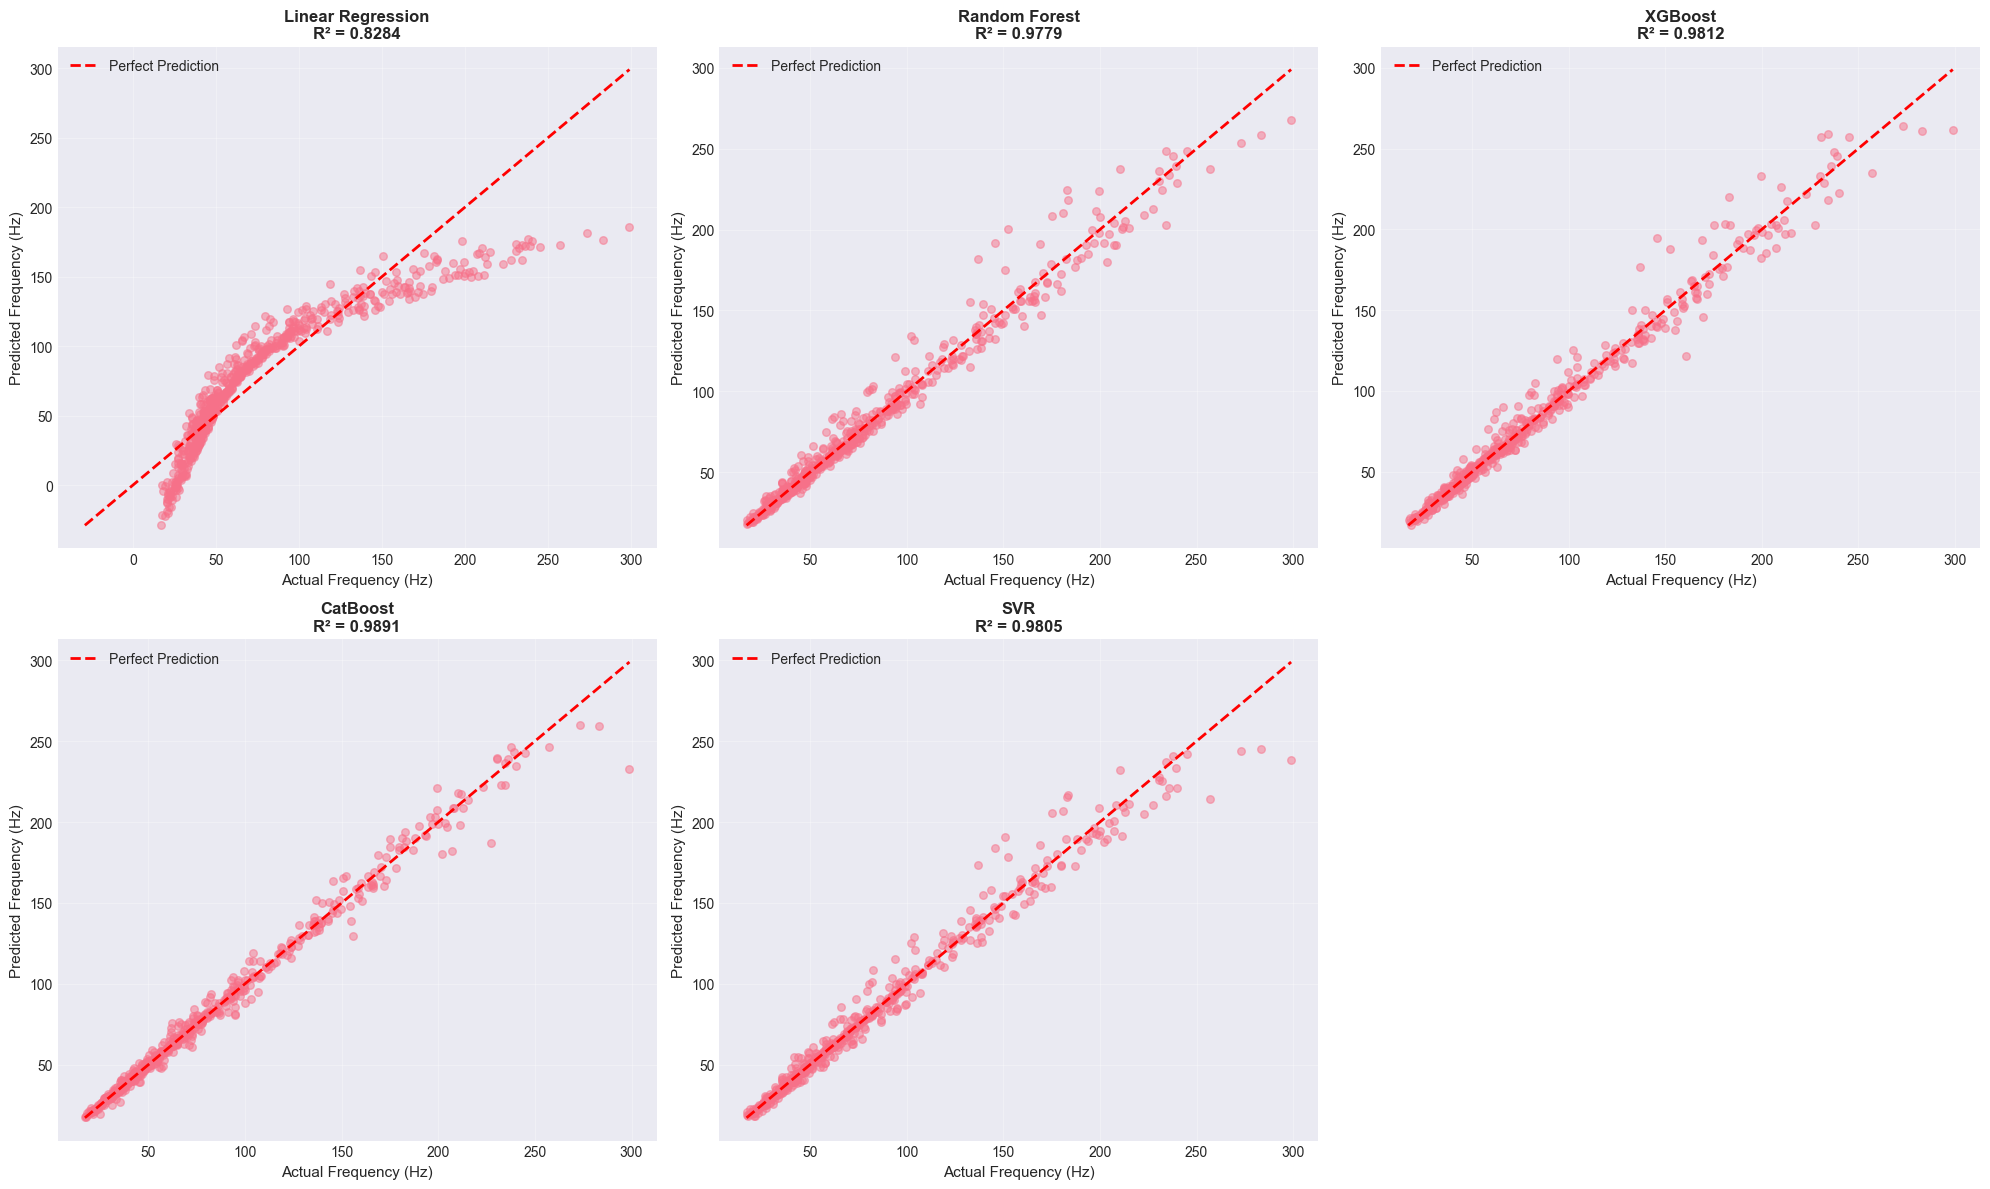

2025-11-26 21:36:36,516 - INFO - ✓ Prediction vs actual plot saved


In [25]:
# Prediction vs Actual for all models
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

for idx, (model_name, (model, predictions)) in enumerate(models.items()):
    ax = axes[idx]
    ax.scatter(y_test, predictions, alpha=0.5, s=30)
    
    # Perfect prediction line
    min_val = min(y_test.min(), predictions.min())
    max_val = max(y_test.max(), predictions.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
    
    r2 = r2_score(y_test, predictions)
    ax.set_title(f'{model_name}\nR² = {r2:.4f}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Actual Frequency (Hz)', fontsize=11)
    ax.set_ylabel('Predicted Frequency (Hz)', fontsize=11)
    ax.legend()
    ax.grid(alpha=0.3)

# Hide last subplot
axes[5].axis('off')

plt.tight_layout()
plt.savefig(output_dir / 'prediction_vs_actual.png', dpi=300, bbox_inches='tight')
plt.show()
logger.info("✓ Prediction vs actual plot saved")

## 8. Residual Analysis

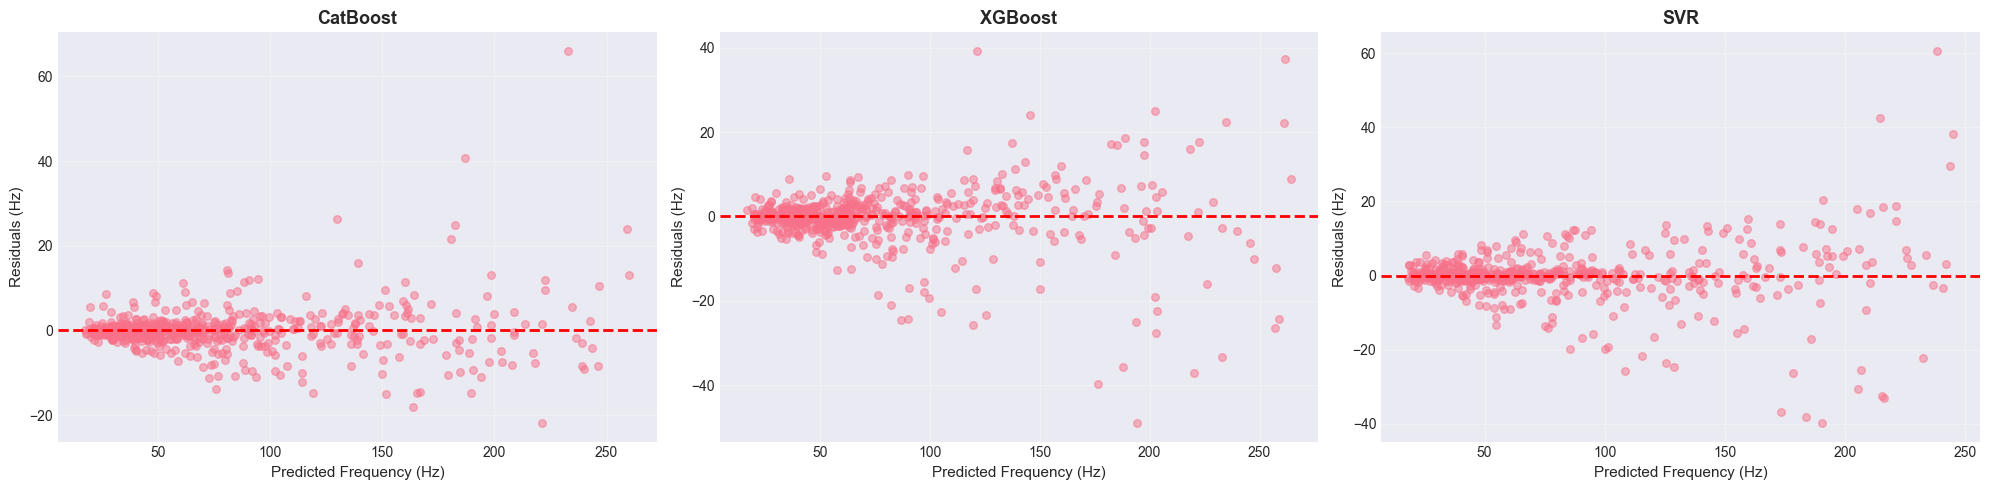

2025-11-26 21:36:36,976 - INFO - ✓ Residual plots saved


In [26]:
# Residual plots for top 3 models
top_models = results_df.nlargest(3, 'Test_R2')['Model'].tolist()

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

for idx, model_name in enumerate(top_models):
    model, predictions = models[model_name]
    residuals = y_test - predictions
    
    ax = axes[idx]
    ax.scatter(predictions, residuals, alpha=0.5, s=30)
    ax.axhline(y=0, color='r', linestyle='--', lw=2)
    ax.set_title(f'{model_name}', fontsize=13, fontweight='bold')
    ax.set_xlabel('Predicted Frequency (Hz)', fontsize=11)
    ax.set_ylabel('Residuals (Hz)', fontsize=11)
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(output_dir / 'residual_plots.png', dpi=300, bbox_inches='tight')
plt.show()
logger.info("✓ Residual plots saved")

## 9. Feature Importance Analysis

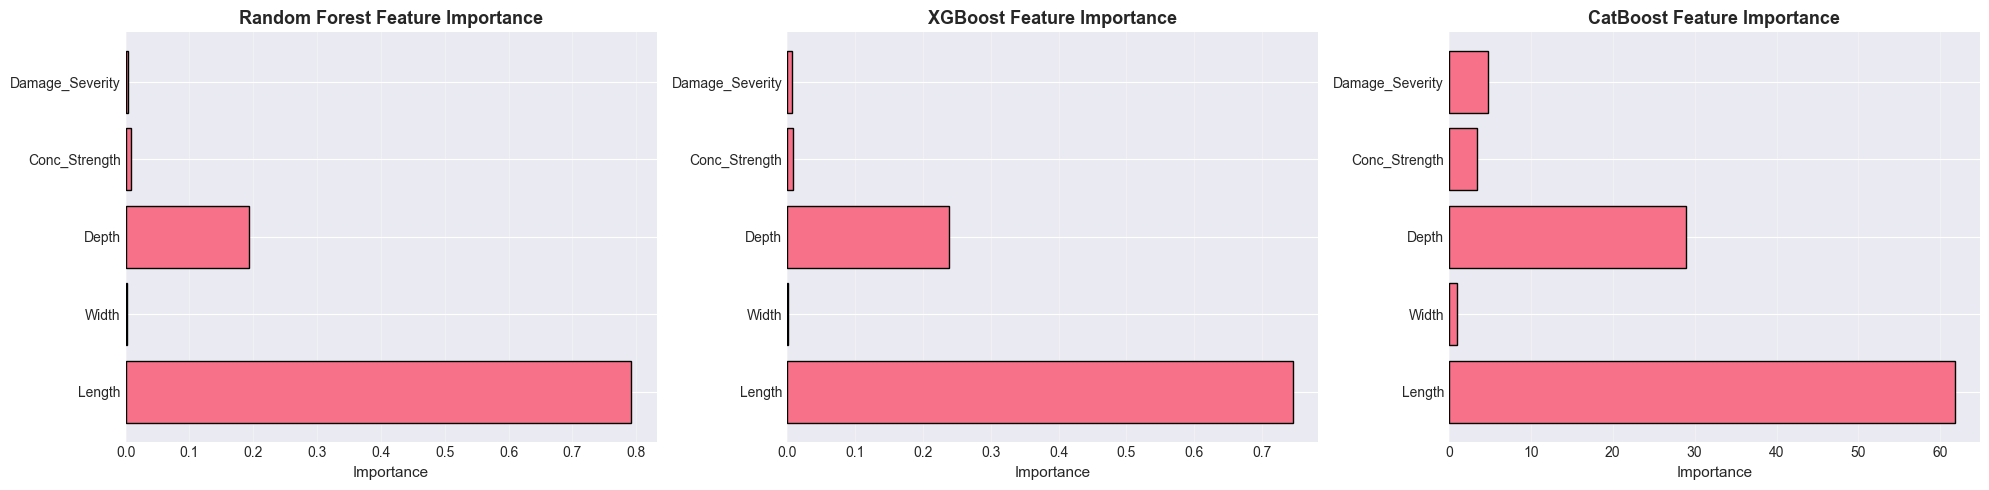

2025-11-26 21:36:37,418 - INFO - ✓ Feature importance plot saved


In [27]:
# Feature importance for tree-based models
tree_models = ['Random Forest', 'XGBoost', 'CatBoost']

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

for idx, model_name in enumerate(tree_models):
    model, _ = models[model_name]
    
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    else:
        importances = model.get_feature_importance()
    
    ax = axes[idx]
    y_pos = np.arange(len(feature_cols))
    ax.barh(y_pos, importances, edgecolor='black')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(feature_cols)
    ax.set_xlabel('Importance', fontsize=11)
    ax.set_title(f'{model_name} Feature Importance', fontsize=13, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(output_dir / 'feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()
logger.info("✓ Feature importance plot saved")

## 10. SHAP Analysis

2025-11-26 21:36:37,426 - INFO - 
Performing SHAP analysis for best model: CatBoost


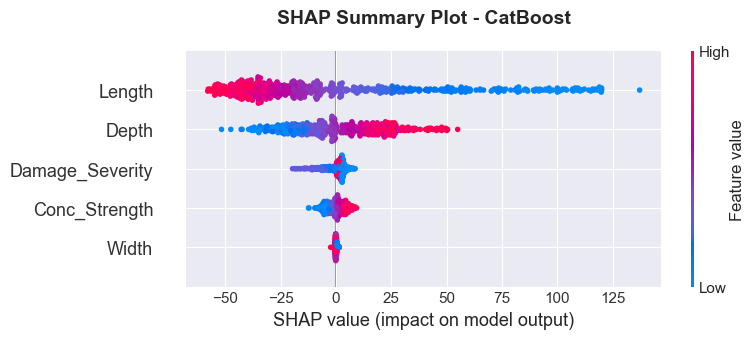

2025-11-26 21:36:38,162 - INFO - ✓ SHAP summary plot saved


In [28]:
# SHAP for best model
best_model_name = results_df.loc[results_df['Test_R2'].idxmax(), 'Model']
best_model, _ = models[best_model_name]

logger.info(f"\nPerforming SHAP analysis for best model: {best_model_name}")

# Create SHAP explainer
if best_model_name in ['Random Forest', 'XGBoost', 'CatBoost']:
    explainer = shap.TreeExplainer(best_model)
    shap_values = explainer.shap_values(X_test_scaled)
    
    # Summary plot
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_test_scaled, feature_names=feature_cols, show=False)
    plt.title(f'SHAP Summary Plot - {best_model_name}', fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.savefig(output_dir / 'shap_summary.png', dpi=300, bbox_inches='tight')
    plt.show()
    logger.info("✓ SHAP summary plot saved")
else:
    logger.info("SHAP analysis not available for this model type")

## 11. Save Best Model

In [29]:
# Save best model and scaler
model_dir = Path('simulation/models')
model_dir.mkdir(parents=True, exist_ok=True)

joblib.dump(best_model, model_dir / f'best_model_{best_model_name.replace(" ", "_")}.pkl')
joblib.dump(scaler, model_dir / 'scaler.pkl')

logger.info(f"✓ Best model ({best_model_name}) saved to {model_dir}")
logger.info(f"✓ Scaler saved to {model_dir}")

print(f"\n✓ Best model: {best_model_name}")
print(f"✓ Saved to: {model_dir}")

2025-11-26 21:36:38,173 - INFO - ✓ Best model (CatBoost) saved to simulation/models
2025-11-26 21:36:38,173 - INFO - ✓ Scaler saved to simulation/models



✓ Best model: CatBoost
✓ Saved to: simulation/models


## 12. Prediction Interface

In [30]:
def predict_frequency(length, width, depth, conc_strength, damage_severity):
    """
    Predict natural frequency for given beam parameters.
    
    Parameters:
    -----------
    length : float - Beam length (m)
    width : float - Beam width (m)
    depth : float - Beam depth (m)
    conc_strength : float - Concrete strength (MPa)
    damage_severity : float - Damage severity (0-100%)
    
    Returns:
    --------
    float - Predicted Mode 1 frequency (Hz)
    """
    # Create input array
    input_data = np.array([[length, width, depth, conc_strength, damage_severity]])
    
    # Scale input
    input_scaled = scaler.transform(input_data)
    
    # Predict
    prediction = best_model.predict(input_scaled)[0]
    
    return prediction

# Test prediction function
test_length = 4.0
test_width = 0.3
test_depth = 0.5
test_strength = 35
test_damage = 10

pred_freq = predict_frequency(test_length, test_width, test_depth, test_strength, test_damage)

print("\n" + "="*80)
print("PREDICTION TEST")
print("="*80)
print(f"Input Parameters:")
print(f"  Length: {test_length} m")
print(f"  Width: {test_width} m")
print(f"  Depth: {test_depth} m")
print(f"  Concrete Strength: {test_strength} MPa")
print(f"  Damage Severity: {test_damage}%")
print(f"\nPredicted Mode 1 Frequency: {pred_freq:.2f} Hz")


PREDICTION TEST
Input Parameters:
  Length: 4.0 m
  Width: 0.3 m
  Depth: 0.5 m
  Concrete Strength: 35 MPa
  Damage Severity: 10%

Predicted Mode 1 Frequency: 102.47 Hz


## 13. Final Summary

In [31]:
print("\n" + "="*80)
print("TRAINING SUMMARY")
print("="*80)
print(f"\nDataset Size: {len(df)} samples")
print(f"Training Samples: {len(X_train)}")
print(f"Testing Samples: {len(X_test)}")
print(f"\nFeatures: {', '.join(feature_cols)}")
print(f"\nModels Trained: {len(models)}")
print(f"\nBest Model: {best_model_name}")
best_metrics = results_df[results_df['Model'] == best_model_name].iloc[0]
print(f"  Test R²: {best_metrics['Test_R2']:.4f}")
print(f"  Test MAE: {best_metrics['Test_MAE']:.4f} Hz")
print(f"  Test RMSE: {best_metrics['Test_RMSE']:.4f} Hz")

logger.info("\n" + "="*80)
logger.info("ML TRAINING COMPLETED SUCCESSFULLY")
logger.info("="*80)
logger.info(f"Best Model: {best_model_name} (R² = {best_metrics['Test_R2']:.4f})")

2025-11-26 21:36:38,189 - INFO - 
2025-11-26 21:36:38,189 - INFO - ML TRAINING COMPLETED SUCCESSFULLY
2025-11-26 21:36:38,190 - INFO - ================================================================================
2025-11-26 21:36:38,190 - INFO - Best Model: CatBoost (R² = 0.9891)



TRAINING SUMMARY

Dataset Size: 3000 samples
Training Samples: 2400
Testing Samples: 600

Features: Length, Width, Depth, Conc_Strength, Damage_Severity

Models Trained: 5

Best Model: CatBoost
  Test R²: 0.9891
  Test MAE: 3.0023 Hz
  Test RMSE: 5.6119 Hz
